<a href="https://colab.research.google.com/github/mjsipes/pytorch_notebooks/blob/main/features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import PyTorch and matplotlib
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'2.3.0+cu121'

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


In [ ]:
start = 0
end = 5
step = 0.02
X = torch.arange(start, end, step, dtype=torch.float32).unsqueeze(dim=-1).unsqueeze(dim=-1)
X2 = X*X
X3 = X*X*X
logX = torch.log(X)
expX = torch.pow(2, X)
sinX = torch.sin(X)

weight = 4
bias = 0
y1 = X*weight + bias
y2 = X*X*weight + bias
y3 = X*X*X*weight + bias
logy = torch.log(X)*weight + bias
expy = torch.pow(2, X)*weight + bias
siny = torch.sin((10)*X)*weight + bias

features = [X,sinX]
X = torch.cat(features, dim=1)

y = siny
y = y.squeeze(dim = -1)

X.dtype, y.dtype, X[:5], y[:5]

(torch.float32,
 torch.float32,
 tensor([[[0.0000],
          [0.0000]],
 
         [[0.0200],
          [0.0200]],
 
         [[0.0400],
          [0.0400]],
 
         [[0.0600],
          [0.0600]],
 
         [[0.0800],
          [0.0799]]]),
 tensor([[0.0000],
         [0.7947],
         [1.5577],
         [2.2586],
         [2.8694]]))

In [ ]:
from sklearn.utils import shuffle

train_split = int(0.8 * len(X))
X, y = shuffle(X, y, random_state=42)
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)
X_train.shape

torch.Size([200, 2, 1])

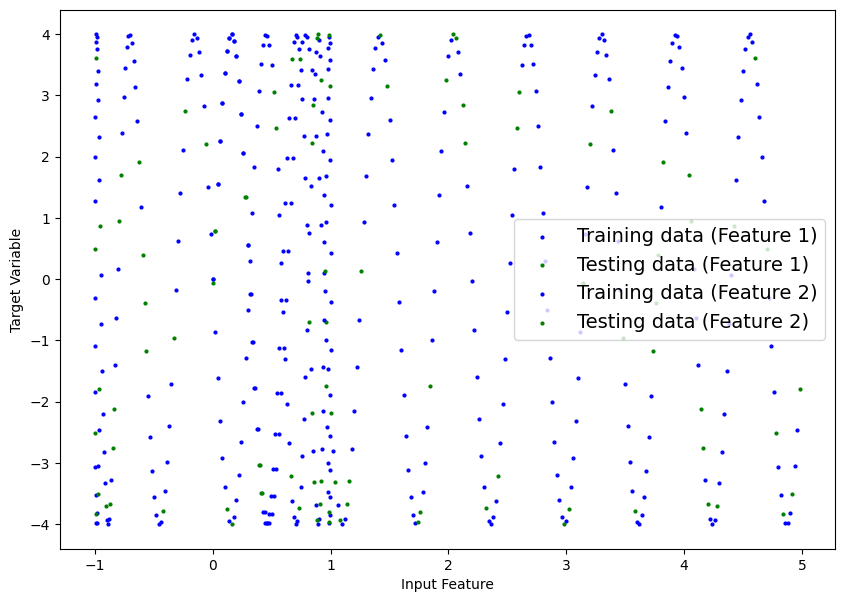

In [ ]:
import matplotlib.pyplot as plt

def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):

  plt.figure(figsize=(10, 7))

  # Iterate over each feature dimension in X
  for i in range(X.shape[1]):
    plt.scatter(train_data[:, i], train_labels, c="b", s=4, label=f"Training data (Feature {i+1})")
    plt.scatter(test_data[:, i], test_labels, c="g", s=4, label=f"Testing data (Feature {i+1})")

  if predictions is not None:
    for i in range(X.shape[1]):
      plt.scatter(test_data[:, i], predictions, c="r", s=4, label="Predictions")

  # Set labels and legend
  plt.xlabel("Input Feature")
  plt.ylabel("Target Variable")
  plt.legend(prop={"size": 14});

# Call the function with your desired data
plot_predictions(X_train, y_train, X_test, y_test)
plt.show()



In [ ]:
X_train.shape, X.shape

(torch.Size([200, 2, 1]), torch.Size([250, 2, 1]))

In [ ]:

in_features=X.shape[1]

class LinearRegressionModel2(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_layer = nn.Linear(in_features,out_features=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.flatten(x)
        x = self.linear_layer(x)
        return x


torch.manual_seed(42)
model_2 = LinearRegressionModel2()

# with torch.no_grad():
#     model_2.linear_layer.weight[0][0] = 0
#     model_2.linear_layer.weight[0][1] = 0
#     model_2.linear_layer.weight[0][2] = 0
#     model_2.linear_layer.bias[0] = 0

# model_2, model_2.state_dict()
model_2.linear_layer.weight[0][0].data


tensor(0.5406)

In [ ]:
in_features=X.shape[1]

model_3 = nn.Sequential(
    nn.Flatten(),
    nn.Linear(in_features, 2),
    nn.ReLU(),
    nn.Linear(2, 2),
    nn.ReLU(),
    nn.Linear(2, 1)
)

# Print the model structure
print(model_3)



Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=2, out_features=2, bias=True)
  (2): ReLU()
  (3): Linear(in_features=2, out_features=2, bias=True)
  (4): ReLU()
  (5): Linear(in_features=2, out_features=1, bias=True)
)


In [ ]:
import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter

%load_ext tensorboard
!rm -rf ./runs/
writer = SummaryWriter()
writer.add_graph(model_2, input_to_model=torch.randn(32, in_features).to(device))

torch.manual_seed(42)

# Initialize model, device, loss function, optimizer, data as before
model = model_3
epochs = 500
debug = True
PRINT10 = epochs / 10
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
X_train, X_test, y_train, y_test = X_train.to(device), X_test.to(device), y_train.to(device), y_test.to(device)


for epoch in range(epochs):
    model.train()
    y_pred = model(X_train)
    loss = loss_fn(y_pred, y_train)
    optimizer.zero_grad()
    loss.backward()

    if epoch % PRINT10 == 0:
        if debug:
            for name, param in model.named_parameters():
                print(f'{name} - Param: {param.data}')
                # writer.add_histogram(f'params/{name}', param.data, epoch)
                # writer.add_histogram(f'gradients/{name}', param.grad, epoch)
                # writer.add_scalars(main_tag=f'{name}',
                #            tag_scalar_dict={"data": param.data,
                #                             "grad": param.grad},
                #            global_step=epoch)

    optimizer.step()

    model.eval()
    with torch.inference_mode():
        test_pred = model(X_test)
        test_loss = loss_fn(test_pred, y_test)

        writer.add_scalars(main_tag="Loss",
                           tag_scalar_dict={"train_loss": loss,
                                            "test_loss": test_loss},
                           global_step=epoch)
    if epoch % PRINT10 == 0:
        if debug:
            print(f'Epoch: {epoch} | Train Loss: {loss.item():.4f} | Test Loss: {test_loss.item():.4f}')
            print('-' * 60)

# Close the TensorBoard writer
writer.close()


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
1.weight - Param: tensor([[ 0.6496, -0.1549],
        [ 0.1427, -0.3443]])
1.bias - Param: tensor([0.4153, 0.6233])
3.weight - Param: tensor([[-0.5188,  0.6146],
        [ 0.1323,  0.5224]])
3.bias - Param: tensor([0.0958, 0.3410])
5.weight - Param: tensor([[-0.0998,  0.5451]])
5.bias - Param: tensor([0.1045])
Epoch: 0 | Train Loss: 8.4196 | Test Loss: 9.3853
------------------------------------------------------------
1.weight - Param: tensor([[ 0.5477,  0.4217],
        [-0.0995, -0.2276]])
1.bias - Param: tensor([0.1998, 0.5126])
3.weight - Param: tensor([[-0.8464,  0.9102],
        [-0.0873,  0.3859]])
3.bias - Param: tensor([0.3152, 0.2398])
5.weight - Param: tensor([[0.4588, 0.4113]])
5.bias - Param: tensor([0.0211])
Epoch: 50 | Train Loss: 7.9339 | Test Loss: 8.1976
------------------------------------------------------------
1.weight - Param: tensor([[ 0.9174,  1.1692],
        [-0.2142, -

In [ ]:
# %tensorboard --logdir=runs

In [ ]:
print(model.state_dict())


OrderedDict([('1.weight', tensor([[1.6897, 2.6422],
        [0.0028, 0.0511]])), ('1.bias', tensor([-0.9581, -0.0173])), ('3.weight', tensor([[-3.1818,  0.6429],
        [ 0.2131,  0.2265]])), ('3.bias', tensor([ 1.5048, -0.0985])), ('5.weight', tensor([[2.1595, 0.3561]])), ('5.bias', tensor([-0.2962]))])


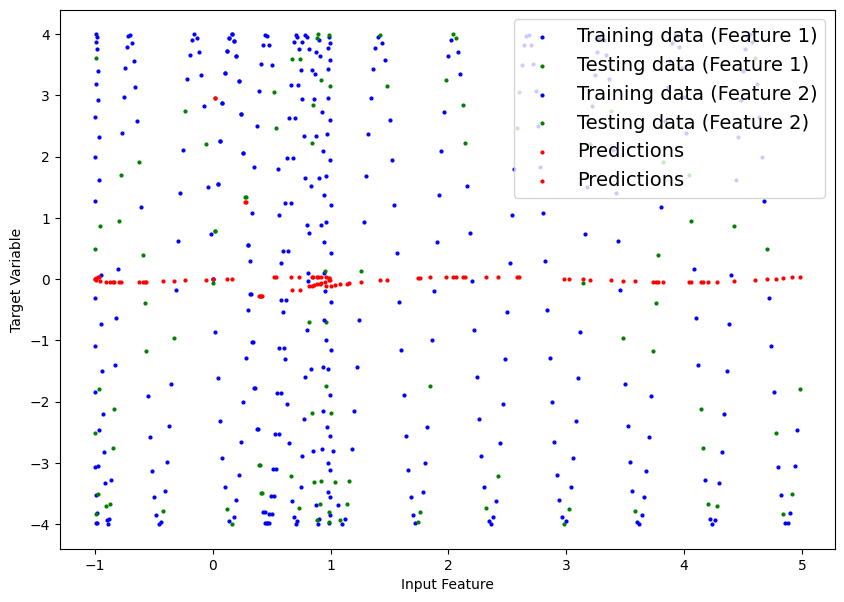

In [ ]:
model.eval()
with torch.inference_mode():
    y_preds = model(X_test)

plot_predictions(predictions=y_preds.cpu())


In [ ]:
#only works with model 2

model.eval()
with torch.inference_mode():
    y_preds = model(X_test)

weights = model.state_dict()['linear_layer.weight'][0]
bias = model.state_dict()['linear_layer.bias'][0]
for i in range(5): #fix!
  print(f"Target: {y_test[i][0]:.2f} | Prediction: {y_preds[i][0]:.2f} == ", end="")
  for j in range(X.shape[1]):
      print(f"{X[i][j][0]:.2f} * {weights[j]:.2f} + ", end="")
  print(f"{bias:.2f}")

# X[1][2][0], X[:5]


KeyError: 'linear_layer.weight'